### Risk Management in Cryptocurrency Trading using Binance API

### 5) Model Training

### Feature Engineering

#### Load the Data

In [4]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os

os.chdir('C:/Users/gerar/OneDrive/Documentos/GitHub/fraudDetection')  # Set the working directory

# List of filenames to load
filenames = ["btc_data.csv", "eth_data.csv", "ftt_data.csv", "xrp_data.csv"]

# Dictionary to store dataframes
dataframes = {}

# Load data for each file
for filename in filenames:
    file_path = os.path.join("data", filename)
    df = pd.read_csv(file_path, parse_dates=["timestamp"])
    symbol = filename.split('_')[0]  # Extract symbol from filename
    dataframes[symbol] = df

# Print the first few rows of each dataframe to check the data
for symbol, df in dataframes.items():
    print(f"\nData for {symbol.upper()}:")
    print(df.head())


Data for BTC:
   timestamp     open     high      low    close       volume     close_time  \
0 2017-08-17  4261.48  4485.39  4200.74  4285.08   795.150377  1503014399999   
1 2017-08-18  4285.08  4371.52  3938.77  4108.37  1199.888264  1503100799999   
2 2017-08-19  4108.37  4184.69  3850.00  4139.98   381.309763  1503187199999   
3 2017-08-20  4120.98  4211.08  4032.62  4086.29   467.083022  1503273599999   
4 2017-08-21  4069.13  4119.62  3911.79  4016.00   691.743060  1503359999999   

   quote_asset_volume  number_of_trades  taker_buy_base_asset_volume  \
0        3.454770e+06              3427                   616.248541   
1        5.086958e+06              5233                   972.868710   
2        1.549484e+06              2153                   274.336042   
3        1.930364e+06              2321                   376.795947   
4        2.797232e+06              3972                   557.356107   

   taker_buy_quote_asset_volume  ignore  
0                  2.678216e+

#### Split the Data

In [5]:
# Define the date range for training and testing
train_start_date = '2020-01-01'
train_end_date = '2022-07-01'
test_start_date = '2022-07-02'
test_end_date = '2022-11-15'

# Split the data into training and testing sets
train_data = {}
test_data = {}

for symbol, df in dataframes.items():
    train_data[symbol] = df[(df['timestamp'] >= train_start_date) & (df['timestamp'] <= train_end_date)]
    test_data[symbol] = df[(df['timestamp'] >= test_start_date) & (df['timestamp'] <= test_end_date)]

# Print the number of rows in the training and testing sets
for symbol in dataframes.keys():
    print(f"\n{symbol.upper()} Training Data: {len(train_data[symbol])} rows")
    print(f"{symbol.upper()} Testing Data: {len(test_data[symbol])} rows")


BTC Training Data: 913 rows
BTC Testing Data: 137 rows

ETH Training Data: 913 rows
ETH Testing Data: 137 rows

FTT Training Data: 913 rows
FTT Testing Data: 137 rows

XRP Training Data: 913 rows
XRP Testing Data: 137 rows


#### Feature engineering

In [6]:
def feature_engineering(df):
    df = df.copy()  # Create a copy of the DataFrame to avoid modifying the original
    df.loc[:, 'daily_return'] = df['close'].pct_change()
    df.loc[:, 'rolling_volatility'] = df['daily_return'].rolling(window=30).std()
    df.loc[:, 'ma_7'] = df['close'].rolling(window=7).mean()
    df.loc[:, 'ma_30'] = df['close'].rolling(window=30).mean()
    df.loc[:, 'day_of_week'] = df['timestamp'].dt.dayofweek
    df.loc[:, 'month'] = df['timestamp'].dt.month
    df.loc[:, 'lagged_return_1'] = df['daily_return'].shift(1)
    df.loc[:, 'lagged_return_2'] = df['daily_return'].shift(2)
    return df.dropna()

# Apply feature engineering to training and testing sets
for symbol in dataframes.keys():
    train_data[symbol] = feature_engineering(train_data[symbol])
    test_data[symbol] = feature_engineering(test_data[symbol])

# Print the first few rows of the BTC training data to check the new features
print(train_data['btc'].head())
print(train_data['eth'].head())

     timestamp     open     high      low    close        volume  \
897 2020-01-31  9511.52  9530.22  9210.01  9352.89  45552.022352   
898 2020-02-01  9351.71  9464.53  9281.00  9384.61  28578.067354   
899 2020-02-02  9384.41  9477.03  9120.00  9331.51  45690.912540   
900 2020-02-03  9331.59  9618.79  9234.00  9292.24  50892.133451   
901 2020-02-04  9291.35  9350.00  9093.01  9197.02  53308.175266   

        close_time  quote_asset_volume  number_of_trades  \
897  1580515199999        4.257790e+08            428547   
898  1580601599999        2.681377e+08            334972   
899  1580687999999        4.280641e+08            446558   
900  1580774399999        4.763800e+08            492124   
901  1580860799999        4.911361e+08            528930   

     taker_buy_base_asset_volume  taker_buy_quote_asset_volume  ignore  \
897                 22482.470899                  2.101503e+08       0   
898                 14679.126305                  1.377641e+08       0   
899     

#### Normalization

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Define the features to be normalized
features = ['close', 'volume', 'daily_return', 'rolling_volatility', 'ma_7', 'ma_30', 'lagged_return_1', 'lagged_return_2']

# Normalize the training and testing sets
for symbol in dataframes.keys():
    train_data[symbol][features] = scaler.fit_transform(train_data[symbol][features])
    test_data[symbol][features] = scaler.transform(test_data[symbol][features])

# Print the first few rows of the normalized BTC training data
print(train_data['btc'].head())
print(train_data['eth'].head())

     timestamp     open     high      low     close    volume     close_time  \
897 2020-01-31  9511.52  9530.22  9210.01  0.072584  0.076985  1580515199999   
898 2020-02-01  9351.71  9464.53  9281.00  0.073090  0.033056  1580601599999   
899 2020-02-02  9384.41  9477.03  9120.00  0.072243  0.077344  1580687999999   
900 2020-02-03  9331.59  9618.79  9234.00  0.071617  0.090805  1580774399999   
901 2020-02-04  9291.35  9350.00  9093.01  0.070099  0.097058  1580860799999   

     quote_asset_volume  number_of_trades  taker_buy_base_asset_volume  \
897        4.257790e+08            428547                 22482.470899   
898        2.681377e+08            334972                 14679.126305   
899        4.280641e+08            446558                 22588.406060   
900        4.763800e+08            492124                 24781.397696   
901        4.911361e+08            528930                 26103.432307   

     taker_buy_quote_asset_volume  ignore  daily_return  rolling_volatilit

#### Train the Model

In [12]:
from sklearn.ensemble import IsolationForest

# Combine the training data from all symbols into a single DataFrame
combined_train_data = pd.concat([train_data[symbol] for symbol in dataframes.keys()])

# Select the features for training
X_train = combined_train_data[features]

# Train the Isolation Forest model
model = IsolationForest(contamination=0.01, random_state=42)
model.fit(X_train)

# Apply the model to each symbol's test data and add the 'anomaly' column
for symbol in dataframes.keys():
    X_test = test_data[symbol][features]
    test_data[symbol]['anomaly'] = model.predict(X_test)

# Print the first few rows of the BTC test data to check the 'anomaly' column
print(test_data['btc'].head())

      timestamp      open      high       low     close    volume  \
1810 2022-08-01  23296.36  23509.68  22850.00  0.294424  0.332314   
1811 2022-08-02  23266.90  23459.89  22654.37  0.289957  0.368192   
1812 2022-08-03  22985.93  23647.68  22681.22  0.287256  0.336813   
1813 2022-08-04  22816.91  23223.32  22400.00  0.284141  0.359862   
1814 2022-08-05  22622.41  23472.86  22586.95  0.295132  0.412650   

         close_time  quote_asset_volume  number_of_trades  \
1810  1659398399999        3.346372e+09           4775213   
1811  1659484799999        3.631021e+09           5066511   
1812  1659571199999        3.385431e+09           4887642   
1813  1659657599999        3.537434e+09           4966138   
1814  1659743999999        4.046436e+09           5340569   

      taker_buy_base_asset_volume  ...  ignore  daily_return  \
1810                  71458.39583  ...       0      0.667268   
1811                  78122.08501  ...       0      0.648711   
1812                  7235

#### Detect Anomalies

In [13]:
# Combine the testing data from all symbols into a single DataFrame
combined_test_data = pd.concat([test_data[symbol] for symbol in dataframes.keys()])

# Select the features for testing
X_test = combined_test_data[features]

# Predict anomalies
combined_test_data['anomaly'] = model.predict(X_test)

# Print the anomalies
anomalies = combined_test_data[combined_test_data['anomaly'] == -1]
print(anomalies)

      timestamp        open        high         low     close     volume  \
1912 2022-11-11  17602.4500  17695.0000  16361.6000  0.195618   0.977617   
1054 2022-11-08     22.0800     22.1000      2.5100  0.044924  10.149141   
1055 2022-11-09      5.4992      6.4600      2.0120  0.003313   9.343258   
1056 2022-11-10      2.2871      4.4136      2.1100  0.019225   9.272848   
1057 2022-11-11      3.5118      3.7499      2.3692  0.007588   5.746335   
1058 2022-11-12      2.6084      2.6350      1.8223  0.001142   4.396784   
1059 2022-11-13      2.1059      2.2900      1.4167 -0.006822   4.658328   
1060 2022-11-14      1.4861      1.9000      1.2300 -0.006746   3.184951   

         close_time  quote_asset_volume  number_of_trades  \
1912  1668211199999        6.725274e+09           9900073   
1054  1667951999999        1.212887e+09           2742536   
1055  1668038399999        5.588741e+08           1794122   
1056  1668124799999        4.099769e+08           1357862   
1057  1668

#### Visualization

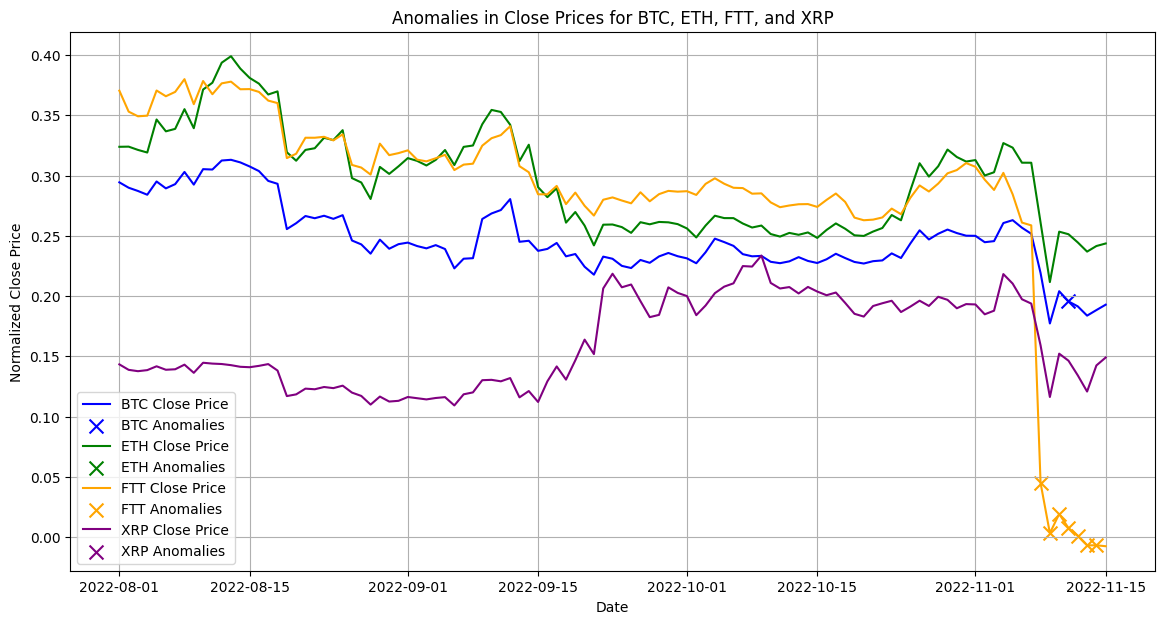

In [14]:
import matplotlib.pyplot as plt

# Define a color map for each ticker
ticker_colors = {
    'btc': 'blue',
    'eth': 'green',
    'ftt': 'orange',
    'xrp': 'purple'
}

# Plot the closing prices with anomalies highlighted for each ticker
plt.figure(figsize=(14, 7))

for symbol in dataframes.keys():
    plt.plot(test_data[symbol]['timestamp'], test_data[symbol]['close'], label=f'{symbol.upper()} Close Price', color=ticker_colors[symbol])
    anomalies = test_data[symbol][test_data[symbol]['anomaly'] == -1]
    plt.scatter(anomalies['timestamp'], anomalies['close'], color=ticker_colors[symbol], marker='x', s=100, label=f'{symbol.upper()} Anomalies')

plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.title('Anomalies in Close Prices for BTC, ETH, FTT, and XRP')
plt.legend()
plt.grid()
plt.show()

#### Model Evaluation

In [15]:
from sklearn.metrics import classification_report

# Combine the testing data from all symbols into a single DataFrame
combined_test_data = pd.concat([test_data[symbol] for symbol in dataframes.keys()])

# Select the features for testing
X_test = combined_test_data[features]

# Predict anomalies
combined_test_data['anomaly'] = model.predict(X_test)

# True labels (assuming you have a way to label the anomalies in the test set)
# For demonstration purposes, let's assume all anomalies are labeled as -1 and normal points as 1
true_labels = combined_test_data['anomaly']  # Replace with actual labels if available

# Classification report
print(classification_report(true_labels, combined_test_data['anomaly']))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00         8
           1       1.00      1.00      1.00       420

    accuracy                           1.00       428
   macro avg       1.00      1.00      1.00       428
weighted avg       1.00      1.00      1.00       428



#### Cross-Validation

In [18]:
from sklearn.metrics import silhouette_score

# Predict anomalies on the training data
train_predictions = model.fit_predict(X_train)

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(X_train, train_predictions)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.3553291660635223


#### One-Class SVM model

In [20]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import silhouette_score

# Initialize the One-Class SVM model
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)

# Fit the model
ocsvm.fit(X_train)

# Predict anomalies on the training data
train_predictions = ocsvm.fit_predict(X_train)

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(X_train, train_predictions)
print("Silhouette Score for One-Class SVM:", silhouette_avg)

Silhouette Score for One-Class SVM: 0.32741174508612714


#### Test Isolation Forest with fresh data from RUNE/USDT

In [22]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# Load the data and skip the first row
data = pd.read_csv('data/rune_data.csv', skiprows=1, header=None, names=['date', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# Convert the date column to datetime
data['date'] = pd.to_datetime(data['date'])

# Filter the last five months
end_date = datetime(2025, 3, 3)
start_date = end_date - pd.DateOffset(months=5)
filtered_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# Apply feature engineering
def feature_engineering(df):
    df = df.copy()
    df['daily_return'] = df['close'].pct_change()
    df['rolling_volatility'] = df['daily_return'].rolling(window=30).std()
    df['ma_7'] = df['close'].rolling(window=7).mean()
    df['ma_30'] = df['close'].rolling(window=30).mean()
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['lagged_return_1'] = df['daily_return'].shift(1)
    df['lagged_return_2'] = df['daily_return'].shift(2)
    return df.dropna()

# Apply feature engineering to the filtered data
filtered_data = feature_engineering(filtered_data)

# Normalize the data
scaler = MinMaxScaler()
features = ['close', 'volume', 'daily_return', 'rolling_volatility', 'ma_7', 'ma_30', 'lagged_return_1', 'lagged_return_2']
filtered_data[features] = scaler.fit_transform(filtered_data[features])

# Predict anomalies on the filtered data
filtered_data['anomaly'] = model.predict(filtered_data[features])

# Print the anomalies
anomalies = filtered_data[filtered_data['anomaly'] == -1]
print(anomalies)

           date   open   high    low     close    volume     close_time  \
1611 2025-02-01  2.125  2.129  1.123  0.000000  0.610292  1738454399999   
1612 2025-02-02  1.166  1.436  0.955  0.026328  1.000000  1738540799999   
1613 2025-02-03  1.334  1.574  1.018  0.051403  0.587282  1738627199999   

      quote_asset_volume  number_of_trades  taker_buy_base_asset_volume  ...  \
1611        3.252389e+08           2050959                  106836976.3  ...   
1612        4.486016e+08           2385107                  182770033.1  ...   
1613        2.827128e+08           1544528                  105328168.4  ...   

      ignore  daily_return  rolling_volatility      ma_7     ma_30  \
1611       0      0.000000            0.931136  0.145898  0.406262   
1612       0      0.797373            0.964565  0.116728  0.380434   
1613       0      0.765039            0.995409  0.094284  0.355338   

      day_of_week  month  lagged_return_1  lagged_return_2  anomaly  
1611            5      2   

#### Plot Results

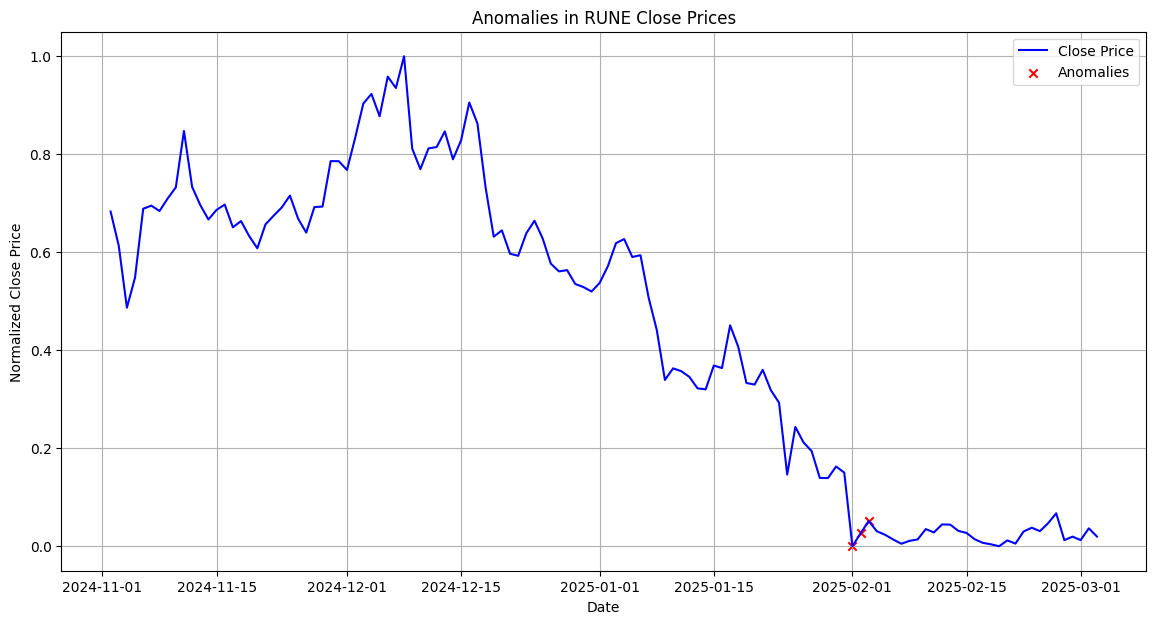

In [23]:
import matplotlib.pyplot as plt

# Plot the closing prices with anomalies highlighted
plt.figure(figsize=(14, 7))
plt.plot(filtered_data['date'], filtered_data['close'], label='Close Price', color='blue')
plt.scatter(filtered_data[filtered_data['anomaly'] == -1]['date'], filtered_data[filtered_data['anomaly'] == -1]['close'], color='red', label='Anomalies', marker='x')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.title('Anomalies in RUNE Close Prices')
plt.legend()
plt.grid()
plt.show()

#### Test One-Class SVM with fresh data from RUNE/USDT

           date   open   high    low     close    volume     close_time  \
1554 2024-12-06  6.765  7.482  6.710  0.958314  0.046299  1733529599999   
1555 2024-12-07  7.282  7.371  7.067  0.935120  0.013312  1733615999999   
1556 2024-12-08  7.133  7.576  6.930  1.000000  0.035254  1733702399999   
1559 2024-12-11  6.075  6.478  5.818  0.811942  0.031167  1733961599999   
1564 2024-12-16  6.454  7.130  6.255  0.905501  0.053125  1734393599999   
1611 2025-02-01  2.125  2.129  1.123  0.000000  1.000000  1738454399999   

      quote_asset_volume  number_of_trades  taker_buy_base_asset_volume  ...  \
1554        1.058801e+08            275672                    7420266.0  ...   
1555        5.658775e+07            153040                    3824764.8  ...   
1556        9.173647e+07            225774                    6208944.8  ...   
1559        7.286918e+07            182304                    5835743.9  ...   
1564        1.110427e+08            355138                    8277532.4  .

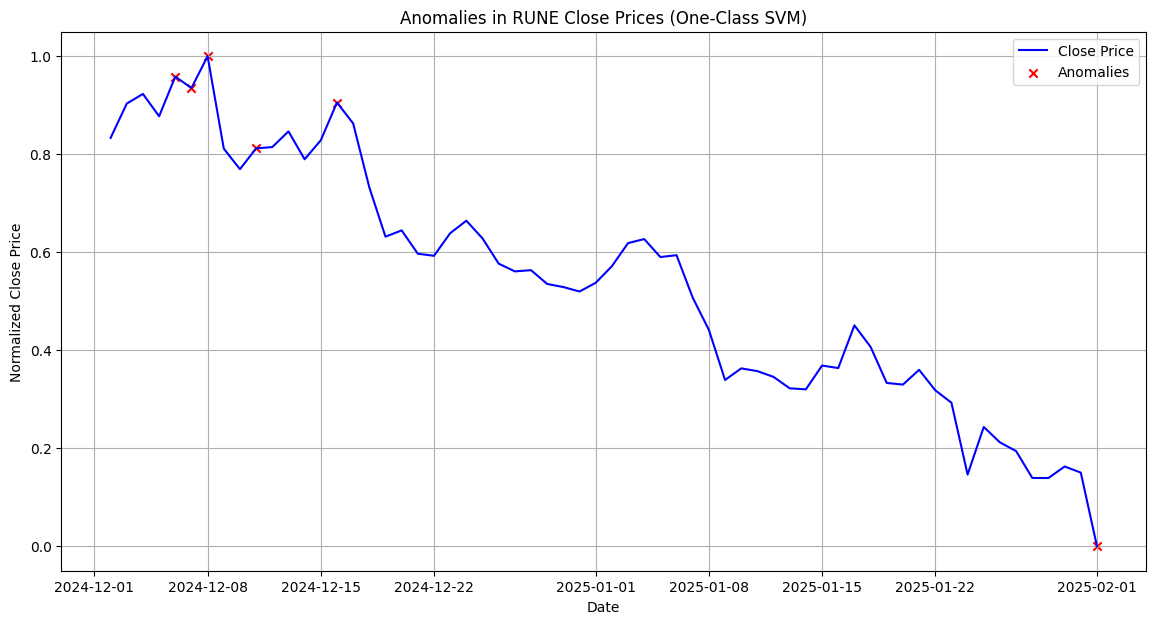

In [24]:
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt

# Train the One-Class SVM model
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)
ocsvm.fit(X_train)

# Apply feature engineering to the RUNE data
def feature_engineering(df):
    df = df.copy()
    df['daily_return'] = df['close'].pct_change()
    df['rolling_volatility'] = df['daily_return'].rolling(window=30).std()
    df['ma_7'] = df['close'].rolling(window=7).mean()
    df['ma_30'] = df['close'].rolling(window=30).mean()
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['lagged_return_1'] = df['daily_return'].shift(1)
    df['lagged_return_2'] = df['daily_return'].shift(2)
    return df.dropna()

# Apply feature engineering to the filtered RUNE data
filtered_data = feature_engineering(filtered_data)

# Normalize the data
scaler = MinMaxScaler()
features = ['close', 'volume', 'daily_return', 'rolling_volatility', 'ma_7', 'ma_30', 'lagged_return_1', 'lagged_return_2']
filtered_data[features] = scaler.fit_transform(filtered_data[features])

# Predict anomalies on the filtered RUNE data using One-Class SVM
filtered_data['anomaly'] = ocsvm.predict(filtered_data[features])

# Print the anomalies
anomalies = filtered_data[filtered_data['anomaly'] == -1]
print(anomalies)

# Plot the closing prices with anomalies highlighted
plt.figure(figsize=(14, 7))
plt.plot(filtered_data['date'], filtered_data['close'], label='Close Price', color='blue')
plt.scatter(filtered_data[filtered_data['anomaly'] == -1]['date'], filtered_data[filtered_data['anomaly'] == -1]['close'], color='red', label='Anomalies', marker='x')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.title('Anomalies in RUNE Close Prices (One-Class SVM)')
plt.legend()
plt.grid()
plt.show()

#### Perform Silhouette Test on Both Models

In [26]:
from sklearn.metrics import silhouette_score

# Predict anomalies on the training data
train_predictions_if = isolation_forest.fit_predict(X_train)
train_predictions_ocsvm = ocsvm.fit_predict(X_train)

# Calculate the Silhouette Score for Isolation Forest
silhouette_avg_if = silhouette_score(X_train, train_predictions_if)
print("Silhouette Score for Isolation Forest:", silhouette_avg_if)

# Calculate the Silhouette Score for One-Class SVM
silhouette_avg_ocsvm = silhouette_score(X_train, train_predictions_ocsvm)
print("Silhouette Score for One-Class SVM:", silhouette_avg_ocsvm)

Silhouette Score for Isolation Forest: 0.3553291660635223
Silhouette Score for One-Class SVM: 0.32741174508612714


#### Hyperparameter Tuning on Isolated Forest

In [31]:
from sklearn.model_selection import KFold
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
import numpy as np

# Define the custom scoring function
def silhouette_scorer(estimator, X):
    predictions = estimator.fit_predict(X)
    return silhouette_score(X, predictions)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 0.5, 0.75],
    'contamination': [0.01, 0.05, 0.1],
    'max_features': [1.0, 0.5, 0.75]
}

# Initialize the model
isolation_forest = IsolationForest(random_state=42)

# Perform grid search with the custom scoring function
best_score = -1
best_params = None

for n_estimators in param_grid['n_estimators']:
    for max_samples in param_grid['max_samples']:
        for contamination in param_grid['contamination']:
            for max_features in param_grid['max_features']:
                isolation_forest.set_params(n_estimators=n_estimators, max_samples=max_samples, contamination=contamination, max_features=max_features)
                scores = []
                for train_index, test_index in KFold(n_splits=5).split(X_train):
                    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
                    score = silhouette_scorer(isolation_forest, X_test_fold)
                    scores.append(score)
                avg_score = np.mean(scores)
                if avg_score > best_score:
                    best_score = avg_score
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_samples': max_samples,
                        'contamination': contamination,
                        'max_features': max_features
                    }

# Print the best parameters and the best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the model with the best parameters
best_isolation_forest = IsolationForest(**best_params, random_state=42)
best_isolation_forest.fit(X_train)

# Predict anomalies on the test data
test_data['anomaly'] = best_isolation_forest.predict(X_test)

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(X_test, test_data['anomaly'])
print("Silhouette Score for Optimized Isolation Forest:", silhouette_avg)

Best Parameters: {'n_estimators': 50, 'max_samples': 'auto', 'contamination': 0.01, 'max_features': 0.75}
Best Score: 0.33842122446261647
Silhouette Score for Optimized Isolation Forest: 0.9163052102189202


#### Test Best Isolation Forest with RUNE/USDT Data

           date    open    high     low     close    volume     close_time  \
256  2021-05-18  18.335  20.800  18.335  1.000000  0.014046  1621382399999   
258  2021-05-20  11.576  15.091  10.270  0.662849  0.025511  1621555199999   
259  2021-05-21  13.578  14.399   8.090  0.502036  0.041177  1621641599999   
263  2021-05-25  10.180  12.699   9.500  0.615271  0.040325  1621987199999   
264  2021-05-26  12.657  14.082  11.872  0.619027  0.023972  1622073599999   
1611 2025-02-01   2.125   2.129   1.123  0.039980  0.614838  1738454399999   
1612 2025-02-02   1.166   1.436   0.955  0.048394  1.000000  1738540799999   
1613 2025-02-03   1.334   1.574   1.018  0.056407  0.592097  1738627199999   

      quote_asset_volume  number_of_trades  taker_buy_base_asset_volume  ...  \
256         1.128890e+08            138490                 2.853507e+06  ...   
258         1.294675e+08            226740                 5.043955e+06  ...   
259         1.695121e+08            251186               

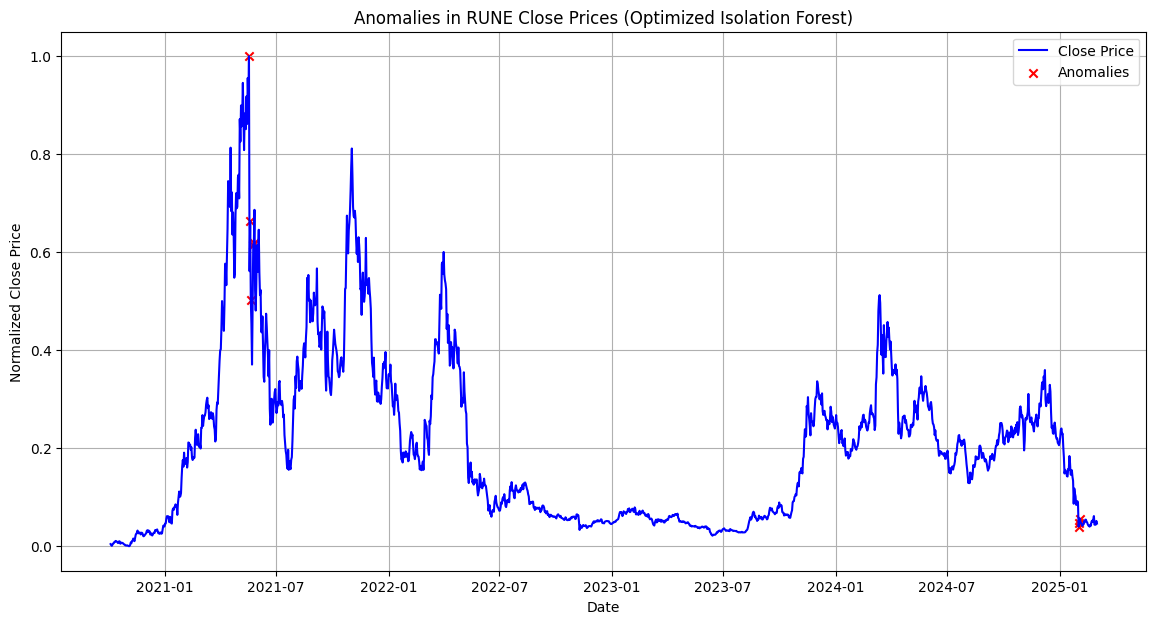

In [41]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the data and skip the first row
rune_data = pd.read_csv('data/rune_data.csv', skiprows=1, header=None, names=['date', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# Convert the date column to datetime
rune_data['date'] = pd.to_datetime(rune_data['date'])

# Apply feature engineering
def feature_engineering(df):
    df = df.copy()
    df['daily_return'] = df['close'].pct_change()
    df['rolling_volatility'] = df['daily_return'].rolling(window=30).std()
    df['ma_7'] = df['close'].rolling(window=7).mean()
    df['ma_30'] = df['close'].rolling(window=30).mean()
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['lagged_return_1'] = df['daily_return'].shift(1)
    df['lagged_return_2'] = df['daily_return'].shift(2)
    return df.dropna()

# Apply feature engineering to the RUNE data
rune_data = feature_engineering(rune_data)

# Normalize the data
scaler = MinMaxScaler()
features = ['close', 'volume', 'daily_return', 'rolling_volatility', 'ma_7', 'ma_30', 'lagged_return_1', 'lagged_return_2']
rune_data[features] = scaler.fit_transform(rune_data[features])

# Predict anomalies on the RUNE data using the optimized model
rune_data['anomaly'] = best_isolation_forest.predict(rune_data[features])

# Print the anomalies
anomalies = rune_data[rune_data['anomaly'] == -1]
print(anomalies)

# Plot the closing prices with anomalies highlighted
plt.figure(figsize=(14, 7))
plt.plot(rune_data['date'], rune_data['close'], label='Close Price', color='blue')
plt.scatter(rune_data[rune_data['anomaly'] == -1]['date'], rune_data[rune_data['anomaly'] == -1]['close'], color='red', label='Anomalies', marker='x')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.title('Anomalies in RUNE Close Prices (Optimized Isolation Forest)')
plt.legend()
plt.grid()
plt.show()

In [43]:
import joblib

# Save the trained model to a file
joblib.dump(best_isolation_forest, 'best_isolation_forest_model.pkl')
print("Model saved successfully.")

Model saved successfully.
